# Q1

## 问题分析

> **问题1**  对经中路-纬中路交叉口，根据**车流量的差异**，可**将一天分成若干个时段**，估计**不同时段各个相位**（包括四个方向直行、转弯）车流量。

对经中路-纬中路交叉口：数据筛选

分为四个相位：需要追踪车牌的流向

分为工作日与非工作日：拆分讨论

每天分为若干时段：聚类

分别估计车流量：根据经验数据估计正常值

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 1. 数据准备

**读取数据**

一定要使用`encoding='gbk'`，否则会报错。

**数据清洗**

+ 去除`'无车牌'`与`'unnnowk'`
+ 去除仅出现过一次的车牌
+ 把时间转化为时间戳
+ 按照车牌-时间排序
+ 替换方向列

In [60]:
original_data = pd.read_csv(r'D:\college\MCM\24\E\Attatchment2.csv', encoding='gbk')

original_data = original_data.loc[(original_data['车牌号']!='无车牌') & (original_data['车牌号']!='unnnowk'),:].copy()
original_data = original_data.loc[original_data['车牌号'].map(original_data['车牌号'].value_counts()) > 1, :].copy()

original_data["时间"] = pd.to_datetime(original_data["时间"])
original_data.sort_values(['车牌号','时间'], inplace=True)

direction_map = {
    1: '由东向西',
    2: '由西向东',
    3: '由南向北',
    4: '由北向南'
}
original_data['方向'] = original_data['方向'].map(direction_map)

original_data

,方向,时间,车牌号,交叉口
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路
...,...,...,...,...
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路
6719735,由北向南,2024-04-26 15:19:03.591,礼OB367Y,经中路-环北路
8625745,由西向东,2024-05-03 16:14:39.000,礼Q36CEA,经中路-环南路


## 工作日与非工作日有较大区别，需要分别考虑

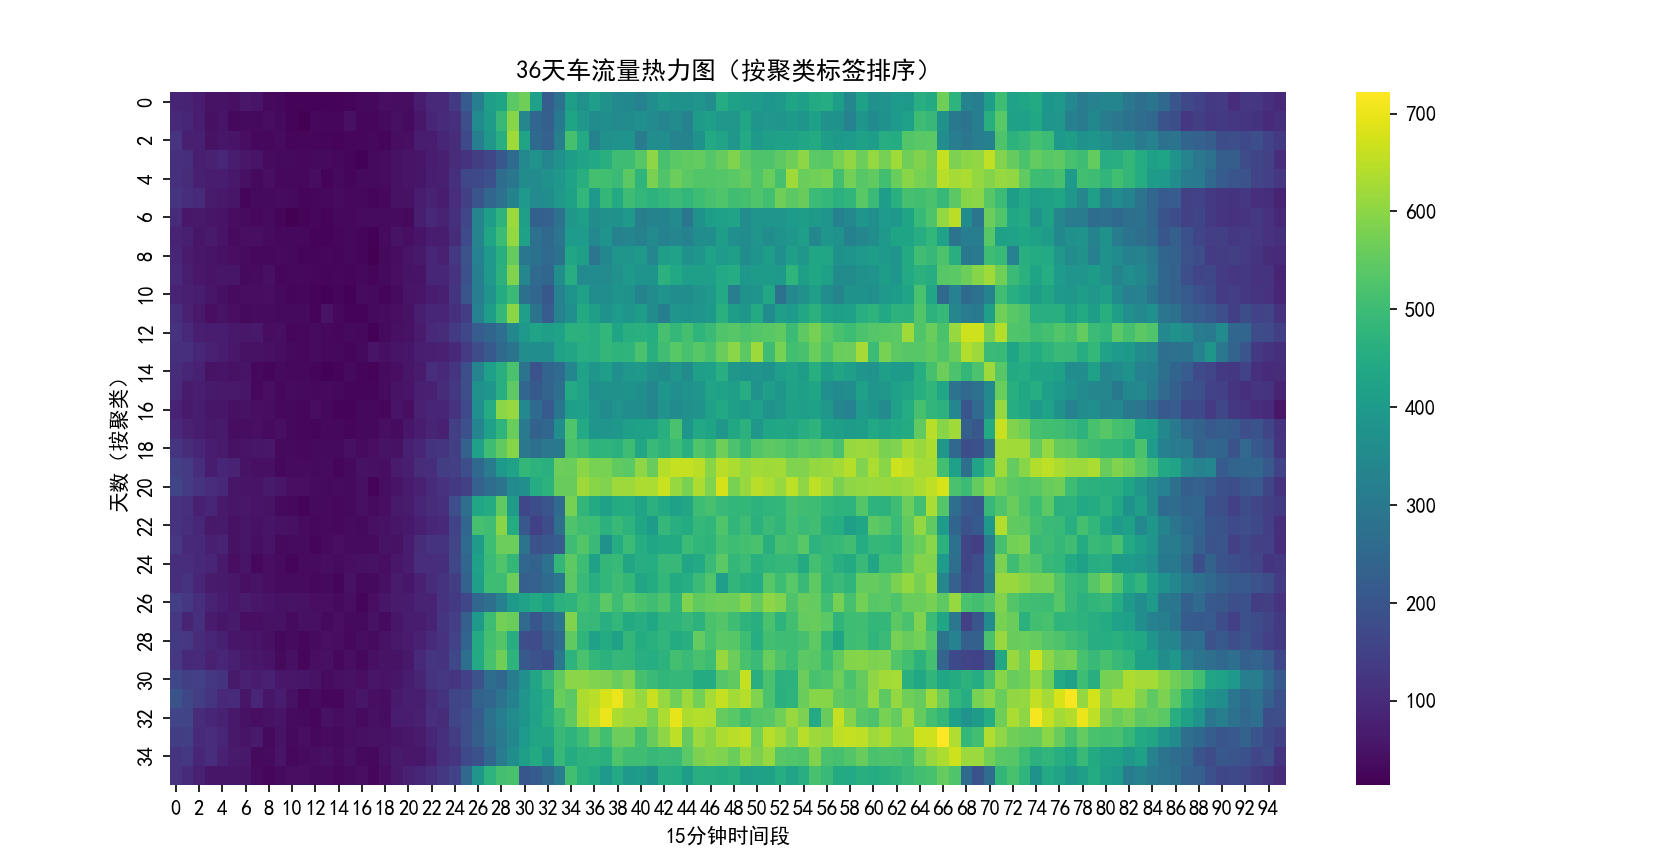

In [61]:

original_data["Hour"] = original_data["时间"].dt.hour
original_data['Month'] = original_data['时间'].dt.month
original_data

,方向,时间,车牌号,交叉口,Hour,Month
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路,17,4
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路,17,4
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路,17,4
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路,19,4
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路,19,4
...,...,...,...,...,...,...
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路,13,4
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路,14,4
6719735,由北向南,2024-04-26 15:19:03.591,礼OB367Y,经中路-环北路,15,4
8625745,由西向东,2024-05-03 16:14:39.000,礼Q36CEA,经中路-环南路,16,5


In [62]:
# 2. 筛选时间范围
mask = (original_data["时间"] >= "2024-04-01") & (original_data["时间"] <= "2024-05-06")
data_period = original_data.loc[mask].copy()

# 3. 定义2024年清明、五一假期和调休补班日
holidays = [
    "2024-04-04", "2024-04-05", "2024-04-06",  # 清明节
    "2024-05-01", "2024-05-02", "2024-05-03", "2024-05-04", "2024-05-05"  # 五一
]
extra_workdays = [
    "2024-04-07", "2024-04-28", "2024-05-11"  # 调休补班日
]

# 4. 新建日期列
data_period["Date"] = data_period["时间"].dt.date.astype(str)

# 5. 判断是否为假期或调休工作日
is_holiday = data_period["Date"].isin(holidays)
is_extra_workday = data_period["Date"].isin(extra_workdays)
is_weekend = data_period["时间"].dt.dayofweek >= 5  # 周六日

# 6. 工作日条件：不是周末且不是法定假日，或调休补班日
workday_mask = ((~is_weekend) & (~is_holiday)) | is_extra_workday
workdays = data_period.loc[workday_mask].copy()

# 7. 非工作日条件：周末或法定假日，且不是调休补班日
nonworkday_mask = (is_weekend | is_holiday) & (~is_extra_workday)
nonworkdays = data_period.loc[nonworkday_mask].copy()

# 8. 结果
# print("工作日样例：")
# print(workdays)
# print("非工作日样例：")
# print(nonworkdays)

工作日与非工作日数据分别为`workdays`、`nonworkdays`

## 追踪每个车牌的去向，判断相位

判定一辆车确实发生了拐弯：

+ 两次出现在路口的时间间隔在一定范围内
+ 两次的方向是头对尾

In [63]:
original_data.loc[original_data['车牌号']=='EF88IJ6',:].copy()

,方向,时间,车牌号,交叉口,Hour,Month
6263754,由北向南,2024-04-06 10:34:14.916,EF88IJ6,经中路-环北路,10,4
6999977,由北向南,2024-04-06 10:35:28.000,EF88IJ6,经中路-纬一路,10,4
5034230,由北向南,2024-04-06 10:37:14.000,EF88IJ6,经中路-纬中路,10,4
4030519,由东向西,2024-04-06 14:40:13.408,EF88IJ6,纬中路-景区出入口,14,4
5027703,由东向西,2024-04-06 14:45:04.000,EF88IJ6,经中路-纬中路,14,4
3373506,由东向西,2024-04-06 14:46:32.206,EF88IJ6,经三路-纬中路,14,4
2875403,由东向西,2024-04-06 14:47:20.063,EF88IJ6,经二路-纬中路,14,4
2156741,由东向西,2024-04-06 14:48:46.615,EF88IJ6,经一路-纬中路,14,4
172760,由东向西,2024-04-06 14:49:21.938,EF88IJ6,环西路-纬中路,14,4
226736,由东向西,2024-04-06 14:49:26.034,EF88IJ6,环西路-纬中路,14,4


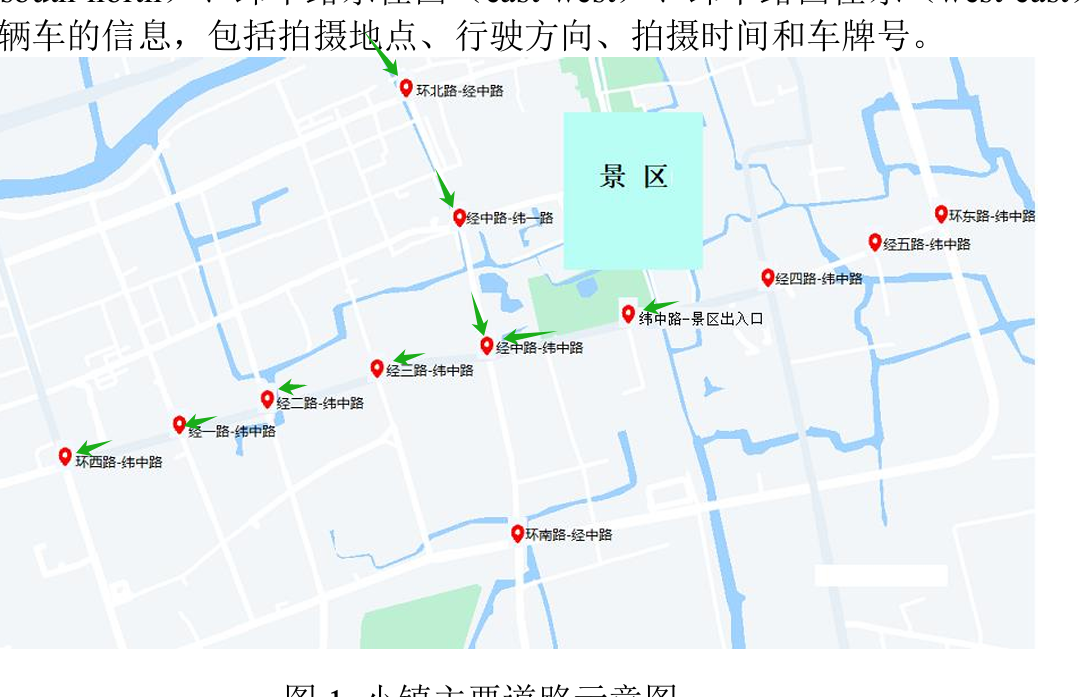

In [64]:
# 计算每辆车相邻两次出现的时间差（单位：秒）
original_data['时间差'] = original_data.groupby('车牌号')['时间'].diff().dt.total_seconds()
time_diff = original_data['时间差'].dropna()
time_diff.sort_values(inplace=True)
time_diff.describe()

count    8.120052e+06
mean     3.910177e+04
std      1.539726e+05
min      0.000000e+00
25%      7.943200e+01
50%      3.600000e+02
75%      1.457884e+04
max      3.105635e+06
Name: 时间差, dtype: float64

取时间间隔中位数360s作为是否为连续出现的判据，符合生活常识

In [65]:
time_diff_std = 360.0

### 奇怪的数据出现了


一辆车同时在两个方向被拍摄到

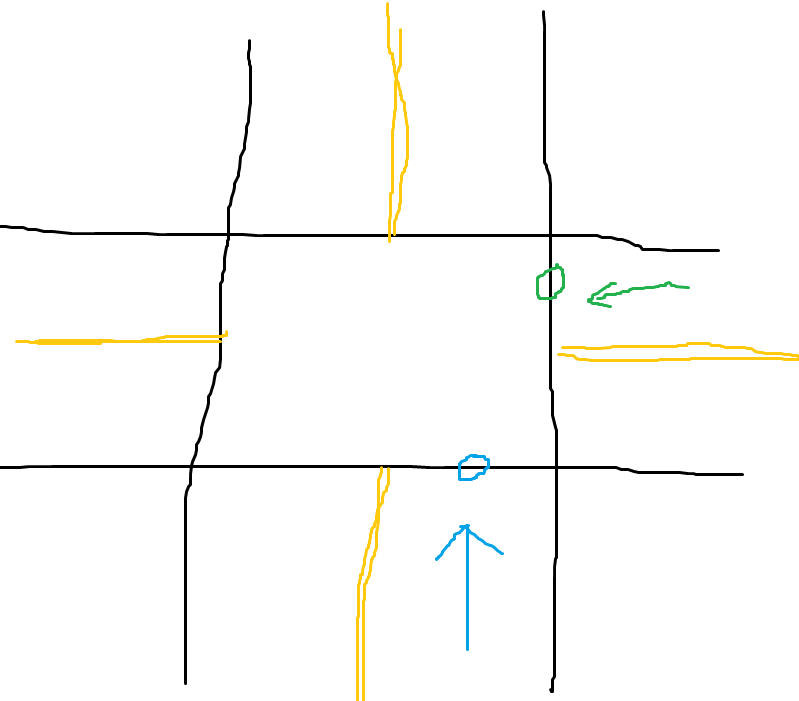

In [66]:
original_data.loc[original_data['时间差']==0.0, :]

,方向,时间,车牌号,交叉口,Hour,Month,时间差
7405430,由南向北,2024-04-26 10:48:07,AF2CCY8,经中路-纬一路,10,4,0.0
7085734,由东向西,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,0.0
5458452,由西向东,2024-04-19 00:32:25,AF4E786K,经中路-纬中路,0,4,0.0
7817945,由西向东,2024-04-05 20:12:19,AF7JAA2,经中路-环南路,20,4,0.0
7145600,由东向西,2024-04-15 10:25:49,AFA45MB,经中路-纬一路,10,4,0.0
7161533,由北向南,2024-04-14 18:43:11,AFS3417,经中路-纬一路,18,4,0.0


In [67]:
original_data.loc[(original_data['车牌号']=='AF3P679') & (original_data['时间']=='2024-04-12 07:11:22'),:].copy()

,方向,时间,车牌号,交叉口,Hour,Month,时间差
7083234,由南向北,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,3.0
7085734,由东向西,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,0.0


## 根据交叉口和方向分组

grouped 的键是 (交叉口, 方向) 的元组，值是对应的小表格

In [68]:
grouped = dict(tuple(original_data.groupby(['交叉口', '方向'])))

print(grouped.keys())

# 例如，查看“环西路-纬中路”交叉口，“东”方向的数据
grouped[('环西路-纬中路', 1)]  #这玩意的类型是DataFrame

dict_keys([('环东路-纬中路', '由东向西'), ('环东路-纬中路', '由北向南'), ('环东路-纬中路', '由南向北'), ('环东路-纬中路', '由西向东'), ('环西路-纬中路', '由东向西'), ('环西路-纬中路', '由北向南'), ('环西路-纬中路', '由南向北'), ('环西路-纬中路', '由西向东'), ('纬中路-景区出入口', '由东向西'), ('纬中路-景区出入口', '由北向南'), ('纬中路-景区出入口', '由南向北'), ('纬中路-景区出入口', '由西向东'), ('经一路-纬中路', '由东向西'), ('经一路-纬中路', '由北向南'), ('经一路-纬中路', '由南向北'), ('经一路-纬中路', '由西向东'), ('经三路-纬中路', '由东向西'), ('经三路-纬中路', '由北向南'), ('经三路-纬中路', '由南向北'), ('经三路-纬中路', '由西向东'), ('经中路-环北路', '由东向西'), ('经中路-环北路', '由北向南'), ('经中路-环北路', '由南向北'), ('经中路-环北路', '由西向东'), ('经中路-环南路', '由东向西'), ('经中路-环南路', '由北向南'), ('经中路-环南路', '由南向北'), ('经中路-环南路', '由西向东'), ('经中路-纬一路', '由东向西'), ('经中路-纬一路', '由北向南'), ('经中路-纬一路', '由南向北'), ('经中路-纬一路', '由西向东'), ('经中路-纬中路', '由东向西'), ('经中路-纬中路', '由北向南'), ('经中路-纬中路', '由南向北'), ('经中路-纬中路', '由西向东'), ('经二路-纬中路', '由东向西'), ('经二路-纬中路', '由西向东'), ('经五路-纬中路', '由东向西'), ('经五路-纬中路', '由北向南'), ('经五路-纬中路', '由南向北'), ('经五路-纬中路', '由西向东'), ('经四路-纬中路', '由东向西'), ('经四路-纬中路', '由北向南'), ('经四路-纬中路', '由南向北'), ('经四路-纬中路', '由西向东')])


KeyError: ('环西路-纬中路', 1)